# Goal 2: Predict whether a respondent has a mental health disorder (Random Forest / Deep Learning with Sentence-BERT)

In [1]:
#!pip install sentence_transformers
#!pip install tf-keras
#!pip install lightgbm
#!pip install scikeras 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from scikeras.wrappers import KerasClassifier

from imblearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
df = pd.read_csv("../data/processed/combined_clean_data.csv")

<br>

# Prepare the Dataset for Machine Learning models

Filter out rows where `Do you currently have a mental health disorder?` is not `Yes` or `No`.
Keep only `Yes` and `No`.


In [4]:
df = df[df["Do you currently have a mental health disorder?"].isin(["Yes","No"])].copy() 
df.columns

Index(['Are you self-employed?',
       'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
       'Do you currently have a mental health disorder?',
       'Do you have a family history of mental illness?',
       'Do you have previous employers?',
       'Do you know the options for mental health care available under your employer-provided health coverage?',
       'Does your employer offer resources to learn more about mental health disorders and options for seeking help?',
       'Does your employer provide mental health benefits as part of healthcare coverage?',
       'Gender_cleaned',
       'Have you ever sought treatment for a mental health disorder from a mental health professional?',
       'Have you had a mental health disorder in the past?',
       'Have you observed or experienced a *supportive or well handled response* to a mental health issue in your current or previous workplace?',
       

### Create binary target

In [5]:
df["Do you currently have a mental health disorder?"] = (df["Do you currently have a mental health disorder?"] == "Yes").astype(int)
31
print(df["Do you currently have a mental health disorder?"].value_counts())
print(df.shape)

Do you currently have a mental health disorder?
1    1368
0    1134
Name: count, dtype: int64
(2502, 26)


## Remove redundant / data-leak columns

Some columns should be removed because they either contain identifiers or information that leaks the target label.
`SurveyID` is purely an ID field and does not provide any meaningful predictive value.


In [6]:
cols_to_drop = [
    "If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?",
    "If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?",
    "SurveyID"
]

df.drop(columns=cols_to_drop, inplace=True)

## Splitting the data
- **`y`** is the target column: `"Do you currently have a mental health disorder?"`
- **`X`** contains all other columns (the features), created by dropping the target column.

In [7]:
y = df["Do you currently have a mental health disorder?"]
X = df.drop(columns=["Do you currently have a mental health disorder?"])



## One-Hot Encoding for machine learning
Convert categorical values to numeric one-hot vectors.

In [8]:
text_col = "all_text"

# Categorical columns (except the text column)
cat_cols = X.select_dtypes(include="object").drop(columns=[text_col]).columns

# Numeric columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Force dense output
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = ohe.fit_transform(X[cat_cols])
X_num = X[num_cols].to_numpy()

## Sentence-BERT Embeddings
We load a Sentence-BERT model and convert the `all_text` column into dense numerical embeddings. These embeddings capture semantic meaning and will be combined with the other features.

In [9]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

texts = X["all_text"].tolist()
embeddings = model.encode(texts, show_progress_bar=True)

X_final = np.hstack([X_cat, X_num, embeddings])

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [10]:
ohe_cols = ohe.get_feature_names_out(cat_cols)
num_cols_list = num_cols.tolist()
embedding_cols = [f"embed_{i}" for i in range(embeddings.shape[1])]

all_columns = list(ohe_cols) + num_cols_list + embedding_cols

df_final = pd.DataFrame(X_final, columns=all_columns)
df_final.head()

,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_No,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_Partial,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_Unknown,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_Yes,Do you have a family history of mental illness?_No,Do you have a family history of mental illness?_Unknown,Do you have a family history of mental illness?_Yes,Do you know the options for mental health care available under your employer-provided health coverage?_No,Do you know the options for mental health care available under your employer-provided health coverage?_Unknown,Do you know the options for mental health care available under your employer-provided health coverage?_Yes,...,embed_758,embed_759,embed_760,embed_761,embed_762,embed_763,embed_764,embed_765,embed_766,embed_767
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.026818,-0.015413,0.021294,0.044119,-0.025731,0.019960,0.009756,0.003721,0.036581,0.032038
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.009811,-0.015497,0.006308,0.051385,-0.028361,0.017360,-0.004252,-0.014771,0.040657,0.016266
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.055769,-0.016270,-0.005475,0.000252,-0.023580,0.067008,-0.032347,-0.002063,0.065970,-0.007730
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.041897,-0.008682,-0.018392,0.060992,-0.037049,-0.093029,0.039607,0.016642,0.020170,0.017305
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.000546,-0.042394,-0.004494,0.071748,-0.052826,-0.014231,0.013555,-0.020264,0.053745,-0.025046


## Train/test split
We split the data so that **80%** is used for training the model and **20%** is kept aside for testing. This allows us to evaluate how well the model generalizes to unseen data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size= 0.2, random_state=5)

## Model Evaluation

This section defines a reusable evaluation function that can be applied to any 
classifier that supports `predict()` and (optionally) `predict_proba()` for ROC-AUC.  
If the model exposes `feature_importances_`, the function also reports and plots 
the top-N most important features.

The function computes:

- Confusion matrix  
- Accuracy  
- Precision  
- Recall  
- F1 score  
- ROC-AUC (if probability estimates are available)  
- Classification report  
- Top-N most important features with a bar plot (if supported)


In [12]:
feature_names = df_final.columns
results = []
top_n=20
labels=[1, 0]

def evaluate_model(model, X_test, y_test, feature_names, model_name="Model"):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test.values, y_pred, labels=labels)
    tp, fn = cm[0]
    fp, tn = cm[1]

    

    print("Confusion Matrix:")
    print(cm)
    print("\n  tp, fn")
    print("  fp, tn\n")

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # ROC-AUC requires positive class probability, if available
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    except:
        roc_auc = None

    print(f"Accuracy:   {accuracy:.3f}")
    print(f"Precision:  {precision:.3f}")
    print(f"Recall:     {recall:.3f}")
    print(f"F1 Score:   {f1:.3f}")
    print(f"ROC-AUC:    {roc_auc:.3f}" if roc_auc is not None else "ROC-AUC:    Not available")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    if hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=feature_names)
        top_features = importances.nlargest(top_n)
        
        top_features.sort_values().plot(kind='barh', figsize=(10, 6))
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"Top {top_n} Most Important Features")
        plt.show()

    else:
        print("\nNo feature importances available for this model.")

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": roc_auc,
        "TP": tp,
        "FN": fn,
        "FP": fp,
        "TN": tn
    }

<br>

# Random Forest Classifier

To improve the performance of the Random Forest model, we perform hyperparameter 
optimization using **RandomizedSearchCV**. Unlike GridSearch, which exhaustively 
tests every combination, RandomizedSearch evaluates a controlled number of random 
parameter combinations, making it significantly faster and often more effective for 
complex models such as Random Forests.

The search runs with **k-fold cross-validation**, allowing the model to be evaluated 
on multiple train/test splits. This makes the tuning process more robust and helps 
prevent overfitting. The parameter space includes tree depth, number of estimators, 
minimum samples per split, feature sampling strategy, and bootstrap settings.

After identifying the best hyperparameters, the optimized model is evaluated using 
our `evaluate_model()` function to ensure consistent reporting of accuracy, 
precision, recall, F1-score, ROC-AUC, and feature importances. This provides a 
fair and comprehensive comparison against the baseline model.


In [13]:
param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rf = RandomForestClassifier(random_state=1, n_jobs=-1)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,              # number of random combinations to try
    scoring="accuracy",
    cv=5,                   # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=1
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_

print("Best params:", search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'bootstrap': True}


Confusion Matrix:
[[247  14]
 [ 58 182]]

  tp, fn
  fp, tn

Accuracy:   0.856
Precision:  0.810
Recall:     0.946
F1 Score:   0.873
ROC-AUC:    0.929

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.83       240
           1       0.81      0.95      0.87       261

    accuracy                           0.86       501
   macro avg       0.87      0.85      0.85       501
weighted avg       0.87      0.86      0.85       501



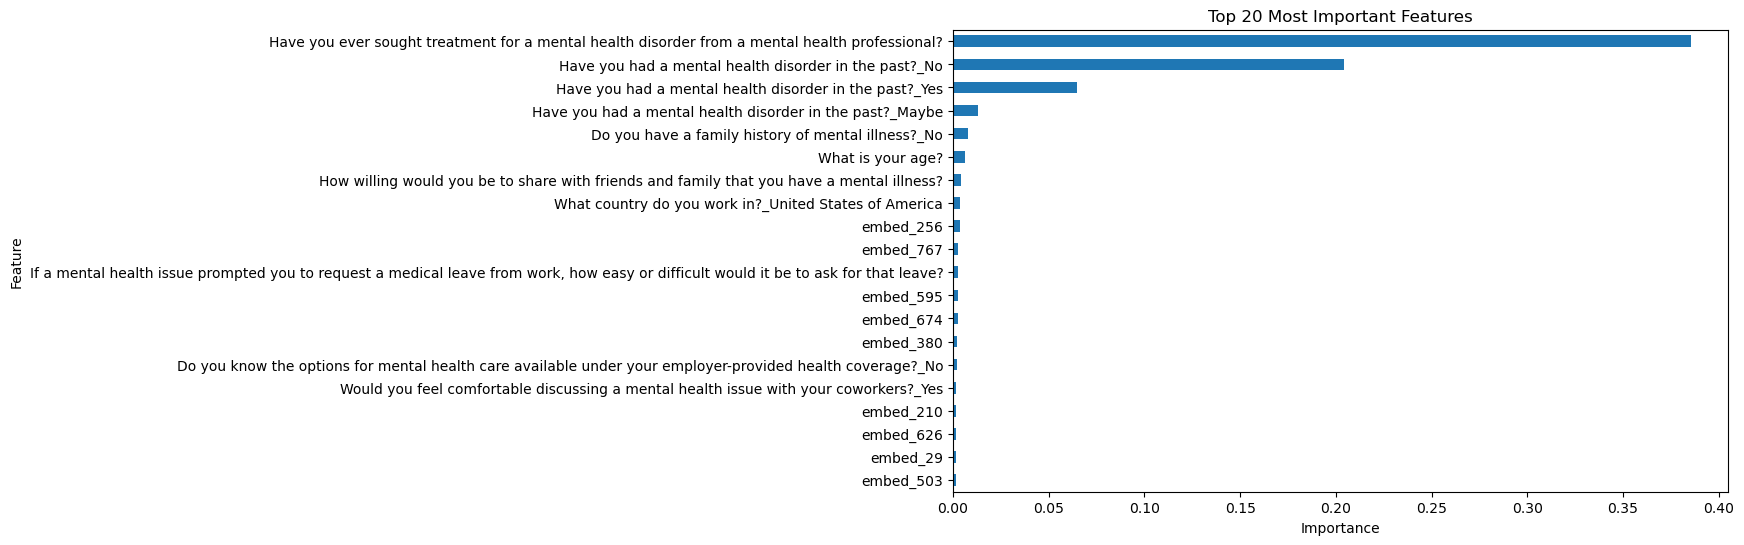

In [14]:
# evaluate_model(
#     model=best_rf,
#     X_test=X_test,
#     y_test=y_test,
#     feature_names=feature_names,
# )
rf = evaluate_model(best_rf, X_test, y_test, feature_names, "Random Forest + Embeddings")
results.append(rf)

# Gradient Boosting

Gradient Boosting is a machine learning method that builds a model step by step. 
Instead of training all decision trees independently (like Random Forest does), 
Gradient Boosting trains each tree to fix the mistakes made by the previous one. 
This sequential learning often results in strong performance, especially on 
structured tabular data.

The method can be quite powerful, but also sensitive to hyperparameters such as 
learning rate, number of trees, and tree depth. With careful tuning Gradient Boosting can provide a solid 
balance between accuracy and generalization.


In [15]:
lgbm = LGBMClassifier(
    objective="binary",
    random_state=1,
    n_jobs=-1
)

param_dist = {
    "num_leaves": [31, 63, 127, 255],
    "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800, 1200, 2000],
    "min_child_samples": [5, 10, 20, 40, 60],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "reg_lambda": [0.0, 0.1, 0.5, 1.0],
}

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=5,           
    scoring="accuracy",
    cv=5,                
    verbose=1,
    random_state=5,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_lgbm = search.best_estimator_

#print("Best parameters:", search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Number of positive: 1107, number of negative: 894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195975
[LightGBM] [Info] Number of data points in the train set: 2001, number of used features: 847
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553223 -> initscore=0.213703
[LightGBM] [Info] Start training from score 0.213703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

C:\Users\karelallik\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\karelallik\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Confusion Matrix:
[[243  18]
 [ 55 185]]

  tp, fn
  fp, tn

Accuracy:   0.854
Precision:  0.815
Recall:     0.931
F1 Score:   0.869
ROC-AUC:    0.922

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84       240
           1       0.82      0.93      0.87       261

    accuracy                           0.85       501
   macro avg       0.86      0.85      0.85       501
weighted avg       0.86      0.85      0.85       501



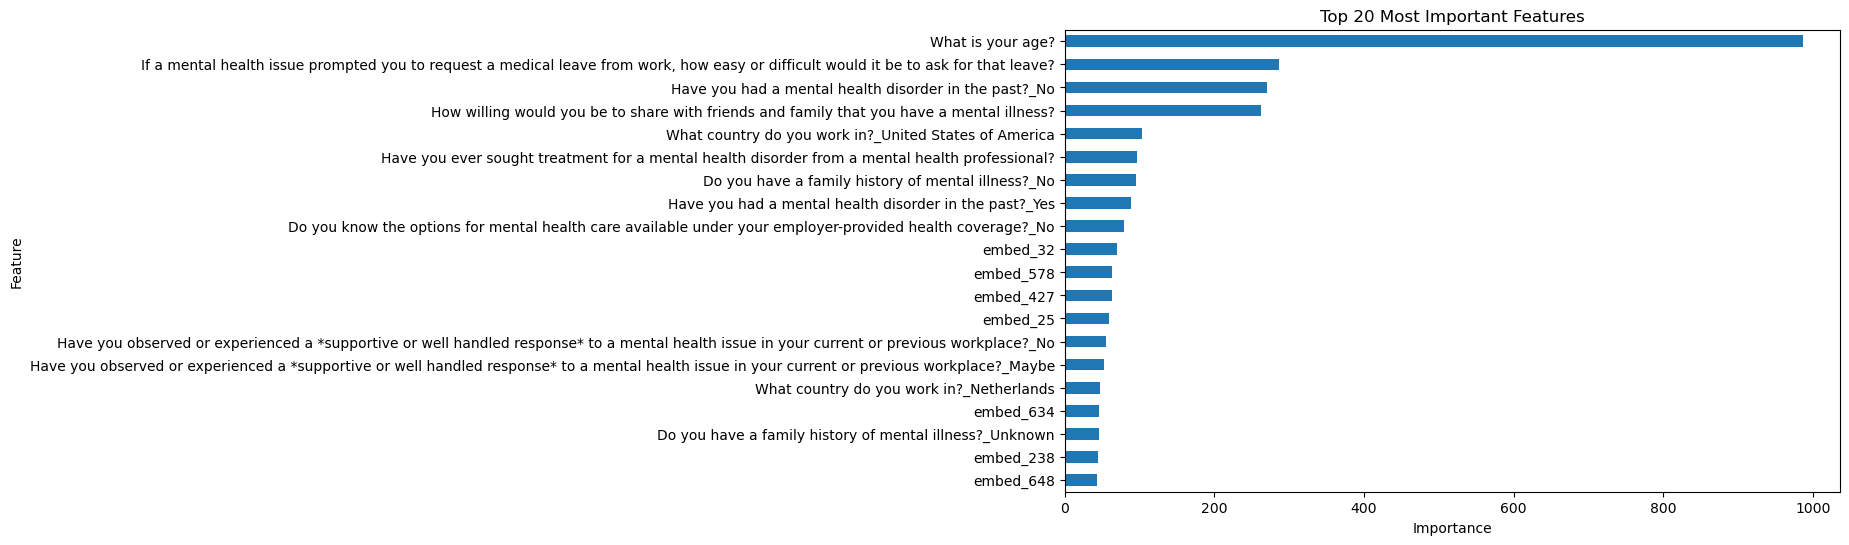

In [16]:
# evaluate_model(
#     model=best_lgbm,
#     X_test=X_test,
#     y_test=y_test,
#     feature_names=feature_names,
# )
lgbm = evaluate_model(best_lgbm, X_test, y_test, feature_names, "Gradient Boosting")
results.append(lgbm)

<br>
<br>

## Kernel SVM

A Kernel SVM builds on the basic linear support vector machine by allowing the decision boundary to be nonlinear. This is done using the kernel trick, which implicitly maps the input data into a higher-dimensional feature space. In this pipeline, we use the RBF (Radial Basis Function) kernel, which can create smooth, flexible boundaries that capture complex patterns in the data.   

To address class imbalance, we also include **SMOTE** in the pipeline.Two important hyperparameters control the behavior of the model: `C`, 
which determines how strictly misclassifications are penalized, and `gamma`, 
which defines how far the influence of a single training point reaches. Tuning 
these parameters using cross-validation can help the model generalize more 
effectively.

In [17]:
param_dist = {
    "clf__C": np.logspace(-2, 2, 15),
    "clf__gamma": np.logspace(-3, 1, 15),
}
# Pipeline:
# SMOTE - balances classes by generating synthetic minority samples
# SVC - RBF kernel SVM model
svc_pipeline = Pipeline([
    ("smote", SMOTE(k_neighbors=5, random_state=1)),
    ("clf", SVC(kernel="rbf", probability=True))
])


search = RandomizedSearchCV(
    svc_pipeline,
    param_distributions=param_dist,
    n_iter=5,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=1
)

search.fit(X_train, y_train)
best_svc = search.best_estimator_

print("Best parameters:", search.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'clf__gamma': np.float64(0.001), 'clf__C': np.float64(51.794746792312075)}


In [18]:
# evaluate_model(
#     model=best_svc,
#     X_test=X_test,
#     y_test=y_test,
#     feature_names=feature_names,
# )
svc = evaluate_model(best_svc, X_test, y_test, feature_names, "Kernel SVM")
results.append(svc)

Confusion Matrix:
[[238  23]
 [ 51 189]]

  tp, fn
  fp, tn

Accuracy:   0.852
Precision:  0.824
Recall:     0.912
F1 Score:   0.865
ROC-AUC:    0.922

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       240
           1       0.82      0.91      0.87       261

    accuracy                           0.85       501
   macro avg       0.86      0.85      0.85       501
weighted avg       0.86      0.85      0.85       501


No feature importances available for this model.


<br>
<br>

# Does embedding make the model better?

To answer this question, we evaluate three different versions of the feature set:

1. **Without embeddings**  
   Only the categorical and numerical features are used. This serves as the 
   baseline accuracy and shows how well the model performs using structured data 
   alone.

2. **With raw embeddings**  
   The full 768-dimensional embeddings are added directly, without PCA. This tests 
   whether the text features help the model in their original form or whether the 
   high dimensionality makes them too noisy.

3. **With PCA-reduced embeddings**  
   The 768-dimensional embeddings are reduced to 256 components using PCA. 
   This helps remove noise and may make it easier for the model to use the text 
   information effectively.

Each of these configurations is evaluated using the same 10-fold stratified 
cross-validation setup to ensure a fair and reliable comparison. By checking the 
average accuracy across folds, we can clearly see whether embeddings improve the 
model, whether PCA helps, and whether the structured features alone are already 
strong enough.


In [19]:
def evaluate(X, y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    model = RandomForestClassifier(random_state=1)
    return cross_val_score(model, X, y, cv=cv, scoring="accuracy")

#baseline
X_no_emb = np.hstack([X_cat, X_num])
scores_no_emb = evaluate(X_no_emb, y)


# Raw embeddings
X_emb_raw = np.hstack([X_cat, X_num, embeddings])
scores_emb_raw = evaluate(X_emb_raw, y)


# PCA-reduced embeddinga
pca = PCA(n_components=256)
X_emb_pca = pca.fit_transform(embeddings)
X_with_pca = np.hstack([X_cat, X_num, X_emb_pca])

scores_with_pca = evaluate(X_with_pca, y)

print("Without embeddings:", scores_no_emb.mean())
print("With raw embeddings:", scores_emb_raw.mean())
print("With PCA embeddings:", scores_with_pca.mean())


Without embeddings: 0.8701163346613546
With raw embeddings: 0.8493243027888446
With PCA embeddings: 0.8537211155378486


## Impact of Embeddings on Model Performance

The results show that adding text embeddings does not improve model accuracy and in fact reduces it, both in their raw form and after PCA dimensionality reduction. The structured categorical and numerical features alone provide the highest accuracy, suggesting that the embeddings introduce noise rather than useful signal. This indicates that the textual information in the dataset is either not informative for the prediction task or not represented in a way that benefits tree-based models.


<br>

<br>
<br>

## Random Forest without embeddings

Once again we perform hyperparameter optimization using **RandomizedSearchCV**. After identifying the best hyperparameters, the optimized model is evaluated again using our `evaluate_model()` function to assess its performance based solely on categorical and numerical features.

In [20]:
X_no_emb = np.hstack([X_cat, X_num])

X_train_ne, X_test_ne, y_train_ne, y_test_ne = train_test_split(X_no_emb, y, test_size= 0.2, random_state=5)

In [21]:
param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rf = RandomForestClassifier(random_state=1, n_jobs=-1)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=1,              # number of random combinations to try
    scoring="accuracy",
    cv=5,                   # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=1
)

search.fit(X_train_ne, y_train_ne)
rf_no_emb = search.best_estimator_

print("Best params:", search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}


In [22]:
# Õige feature nimede loogika ilma embeddinguteta
ohe_cols = ohe.get_feature_names_out(cat_cols)
num_cols_list = num_cols.tolist()
feature_names_no_emb = list(ohe_cols) + num_cols_list


Confusion Matrix:
[[243  18]
 [ 52 188]]

  tp, fn
  fp, tn

Accuracy:   0.860
Precision:  0.824
Recall:     0.931
F1 Score:   0.874
ROC-AUC:    0.922

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       240
           1       0.82      0.93      0.87       261

    accuracy                           0.86       501
   macro avg       0.87      0.86      0.86       501
weighted avg       0.87      0.86      0.86       501



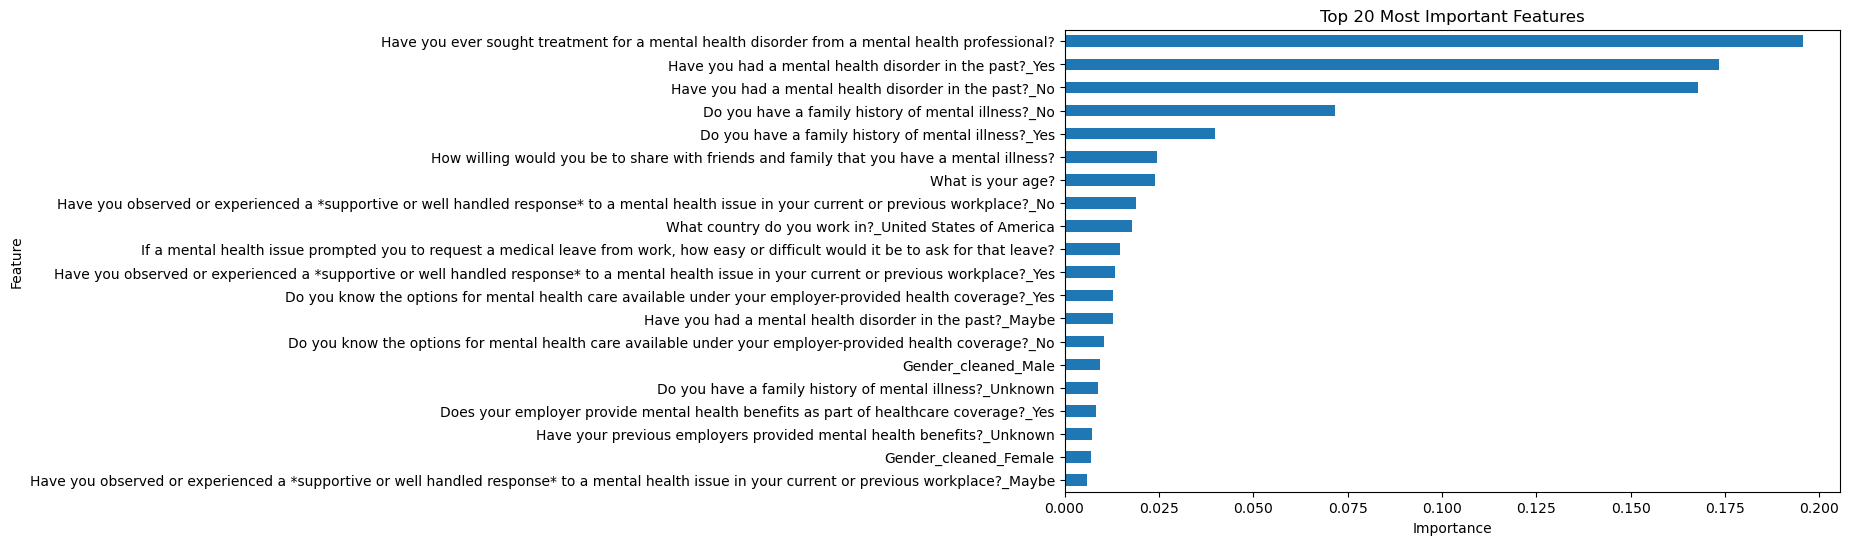

In [23]:
rf_no = evaluate_model(
    model=rf_no_emb,
    X_test=X_test_ne,
    y_test=y_test_ne,
    feature_names=feature_names_no_emb,# <-- uus argument
    model_name= "Random Forest, no embeddings"
)
results.append(rf_no)

Embeddings amplify the signal of key features, especially those related to personal mental health history and treatment. The model with embeddings becomes more confident in a few dominant features, while the model without embeddings distributes importance more evenly. Embedding dimensions themselves become influential, suggesting that semantic information from text is being used effectively.

<br>
<br>

## Multi-Layer Perceptron (MLP)

An MLP is a feedforward neural network composed of multiple fully connected layers. Each neuron applies a nonlinear activation function to learn complex patterns from the input data. MLPs are especially effective for structured data and dense embeddings, such as those generated by Sentence-BERT.

Unlike tree-based models or SVMs, MLPs learn representations through backpropagation and gradient descent, making them flexible but sensitive to overfitting and scale.

A function to build a customizable Multi-Layer Perceptron (MLP) using Keras and wraps it with `KerasClassifier` so it can be used with scikit-learn tools like ``RandomizedSearchCV``.

A simple MLP model for binary classification using Keras. It includes two hidden layers with ReLU activation and dropout, and uses a sigmoid output to predict class probabilities. And then we train the model using early stopping to prevent overfitting. If the validation loss does not improve for three consecutive epochs, training stops and the best weights are restored.

In [24]:
# Loome MLP mudeli
model_MLP = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # esimene peidetud kiht
    Dropout(0.3),                                                     # regulatsioon
    Dense(64, activation='relu'),                                     # teine peidetud kiht
    Dropout(0.3),
    Dense(1, activation='sigmoid')                                    # väljund: tõenäosus klassile 1
])

# Kompileerime mudeli
model_MLP.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

C:\Users\karelallik\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model_MLP.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6181 - loss: 0.6691 - val_accuracy: 0.7706 - val_loss: 0.5205
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7681 - loss: 0.4875 - val_accuracy: 0.8130 - val_loss: 0.4008
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8331 - loss: 0.4003 - val_accuracy: 0.8429 - val_loss: 0.3686
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8700 - loss: 0.3438 - val_accuracy: 0.8504 - val_loss: 0.3487
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8650 - loss: 0.3339 - val_accuracy: 0.8504 - val_loss: 0.3445
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8756 - loss: 0.3113 - val_accuracy: 0.8429 - val_loss: 0.3459
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8888 - loss: 0.3023 - val_accuracy: 0.8479 - val_loss: 0.3457
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8856 - loss: 0.2842 - val_accuracy: 0.8429 - val_loss

In [26]:
def evaluate_MLP(model, X_test, y_test, model_name="Model"):
    
   
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob > 0.5).astype(int)

    cm = confusion_matrix(y_test.values, y_pred, labels=labels)
    tp, fn = cm[0]
    fp, tn = cm[1]

    print("Confusion Matrix:")
    print(cm)
    print("\n  tp, fn")
    print("  fp, tn\n")

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    roc_auc = roc_auc_score(y_test, y_prob)
       

    print(f"Accuracy:   {accuracy:.3f}")
    print(f"Precision:  {precision:.3f}")
    print(f"Recall:     {recall:.3f}")
    print(f"F1 Score:   {f1:.3f}")
    print(f"ROC-AUC:    {roc_auc:.3f}" if roc_auc is not None else "ROC-AUC:    Not available")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": roc_auc,
        "TP": tp,
        "FN": fn,
        "FP": fp,
        "TN": tn
    }

In [27]:
# evaluate_MLP(
#     model=model_MLP,
#     X_test=X_test,
#     y_test=y_test
# )

mlp = evaluate_MLP(
    model=model_MLP,
    X_test=X_test,
    y_test=y_test,
    model_name= "MLP"
)
results.append(mlp)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Confusion Matrix:
[[237  24]
 [ 48 192]]

  tp, fn
  fp, tn

Accuracy:   0.856
Precision:  0.832
Recall:     0.908
F1 Score:   0.868
ROC-AUC:    0.922

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       240
           1       0.83      0.91      0.87       261

    accuracy                           0.86       501
   macro avg       0.86      0.85      0.86       501
weighted avg       0.86      0.86      0.86       501



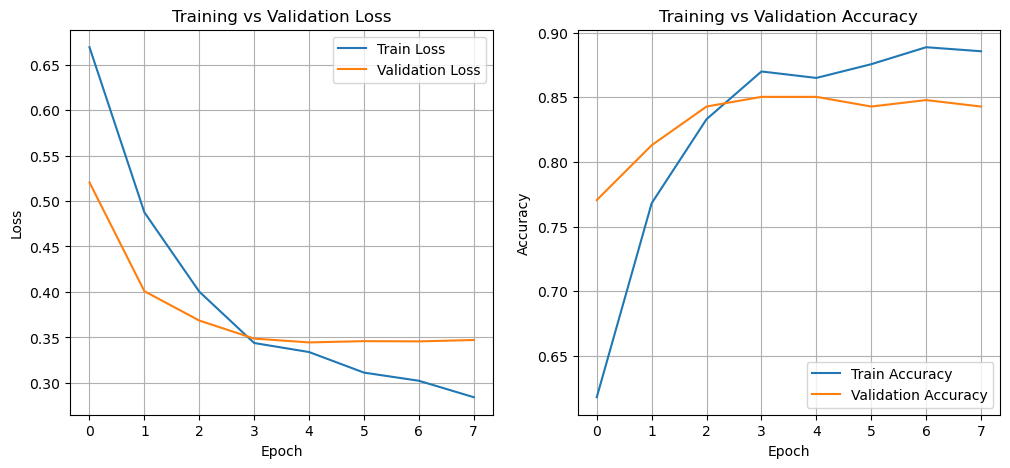

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# ROC Curve Comparison (Random Forest, LightGBM, Kernel SVM)

To visually compare the performance of our tuned models, we plot all three ROC
curves on the same graph.

The ROC curve shows how each model balances true positive rate and false positive
rate across different classification thresholds. The area under the curve (AUC)
summarizes the overall performance: a higher AUC means better discrimination
between the positive and negative classes.


C:\Users\karelallik\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


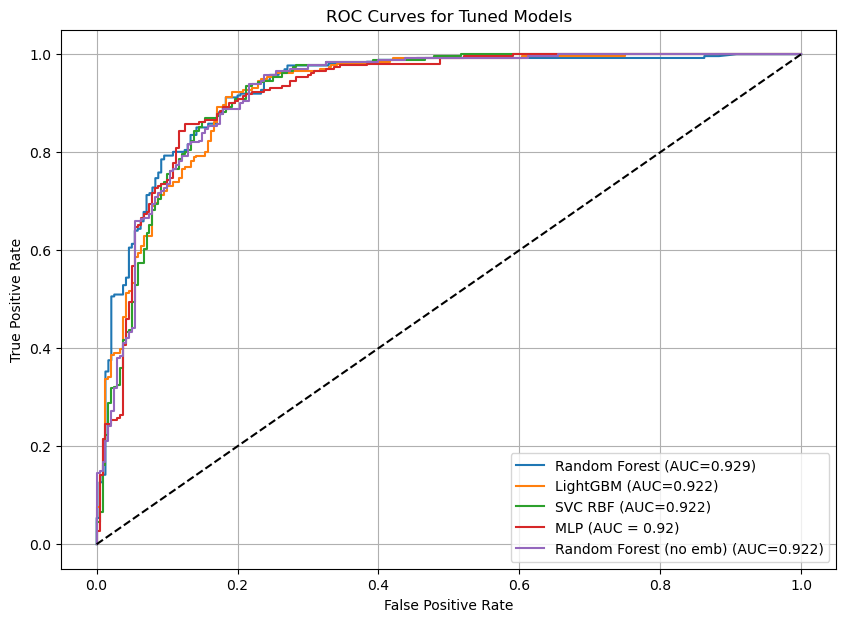

In [29]:

def plot_three_roc(rf, lgbm, svc, mlp, rf_no_emb, X_test, y_test, X_test_ne, y_test_ne):
    plt.figure(figsize=(10, 7))

    y_prob_rf = rf.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    auc_rf = roc_auc_score(y_test, y_prob_rf)
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")

    y_prob_lgbm = lgbm.predict_proba(X_test)[:, 1]
    fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
    auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)
    plt.plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC={auc_lgbm:.3f})")

    y_prob_svc = svc.predict_proba(X_test)[:, 1]
    fpr_svc, tpr_svc, _ = roc_curve(y_test, y_prob_svc)
    auc_svc = roc_auc_score(y_test, y_prob_svc)
    plt.plot(fpr_svc, tpr_svc, label=f"SVC RBF (AUC={auc_svc:.3f})")

    ## MLP
    fpr, tpr, _ = roc_curve(y_test, model_MLP.predict(X_test).ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"MLP (AUC = {roc_auc:.2f})")

    # Random Forest no embeddings
    y_prob_rf = rf_no_emb.predict_proba(X_test_ne)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test_ne, y_prob_rf)
    auc_rf = roc_auc_score(y_test_ne, y_prob_rf)
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (no emb) (AUC={auc_rf:.3f})")
    
    # Chance line
    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Tuned Models")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_three_roc(best_rf, best_lgbm, best_svc, model_MLP, rf_no_emb, X_test, y_test, X_test_ne, y_test_ne)



The ROC curves for all five tuned models: Random Forest, LightGBM, SVC RBF, MLP, and Random Forest without embeddings, show consistently strong performance, with AUC values ranging from `0.920` to `0.929`.

<br>
<br>

## Analysis

                              Accuracy  Precision  Recall     F1  ROC-AUC  \
Model                                                                       
Random Forest + Embeddings       0.856      0.810   0.946  0.873    0.929   
Gradient Boosting                0.854      0.815   0.931  0.869    0.922   
Kernel SVM                       0.852      0.824   0.912  0.865    0.922   
Random Forest, no embeddings     0.860      0.824   0.931  0.874    0.922   
MLP                              0.856      0.832   0.908  0.868    0.922   

                               TP  FN  FP   TN  
Model                                           
Random Forest + Embeddings    247  14  58  182  
Gradient Boosting             243  18  55  185  
Kernel SVM                    238  23  51  189  
Random Forest, no embeddings  243  18  52  188  
MLP                           237  24  48  192  


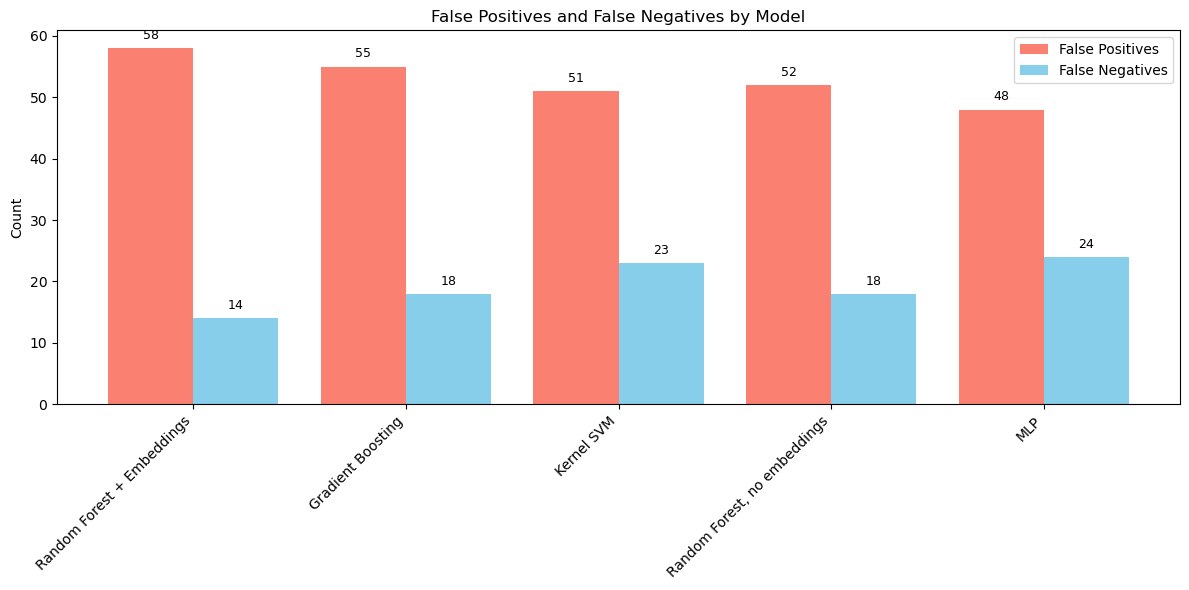

In [30]:
df_models = pd.DataFrame(results).set_index("Model") 

print(df_models.round(3))

x = range(len(df_models))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))

# FP ja FN kõrvuti
ax.bar([i - bar_width/2 for i in x], df_models["FP"], width=bar_width,
       label="False Positives", color="salmon")

ax.bar([i + bar_width/2 for i in x], df_models["FN"], width=bar_width,
       label="False Negatives", color="skyblue")

for i in x:
    ax.text(i - bar_width/2, df_models["FP"].iloc[i] + 1,
            str(df_models["FP"].iloc[i]), ha='center', va='bottom', fontsize=9)
    ax.text(i + bar_width/2, df_models["FN"].iloc[i] + 1,
            str(df_models["FN"].iloc[i]), ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(df_models.index, rotation=45, ha='right')
ax.set_ylabel("Count")
ax.set_title("False Positives and False Negatives by Model")
ax.legend()

plt.tight_layout()
plt.show()

## Limitations

Across all evaluated classification models, the number of **false positives** was consistently `high`, indicating that many individuals were incorrectly flagged as having a disorder despite being healthy. In contrast, the **false negative** counts remained `relatively low`, suggesting that the models were generally effective at identifying individuals who truly had a disorder. This imbalance highlights a tendency toward `overclassification`, where models prioritize sensitivity over precision — potentially leading to unnecessary concern or intervention for some users. While this may reduce the risk of missing true cases, it also underscores the need for better calibration to minimize false alerts.

## Best model:

The best model was Random Forest with embeddings, which achieved the highest overall performance, with an accuracy: `0.856`, F1 Score: `0.873`, and ROC-AUC: `0.929`.
### Why is it better?
Random Forest’s strength lies in its ability to handle `non-linear relationships` and `feature interactions` without overfitting. Compared to SVM and MLP, Random Forest was more robust to `noise` and better at capturing `structured patterns` in categorical and ordinal features. Its ensemble nature allowed it to generalize well across diverse age groups and demographic variables, making it the most reliable choice for this classification task.


<br>
<br>


## Feature insights
<br>

### Random Forest without embeddings:

Top three most important features were: 
1. Have you ever sought treatment for a mental health disorder from a mental health professional?
2. Have you had a mental health disorder in the past? - yes
3. Have you had a mental health disorder in the past? - no

These features stood out with significantly higher predictive importance compared to all others. Each had an importance score starting from `0.16`, while the next highest feature dropped to `0.06`, indicating that these three alone contributed **more than twice as much** to the model’s decision-making as any other individual feature.     

This suggests that personal history and treatment-seeking behavior are the strongest indicators of current mental health status in this dataset. However, the distribution of feature importance is broader, meaning that while the top three features dominate, other variables still contribute meaningfully to the prediction. These include demographic factors like age, openness to discussing mental health, and workplace-related signals.

<br>

### Random Forest with embeddings:
Analyzing the feature importance of the Random Forest model using embeddings, there is a pattern, where the exact same previous three features stand out the most. The first feature alone carries an importance score of `0.4`, which is twice as high as the next most influential feature at `0.2`. This sharp drop-off indicates that the model relies heavily on treatment-seeking behavior as a primary signal for mental health status.

All remaining features including demographic, workplace, and embedded textual signals—have relatively low importance scores, ranging from `0.02` downward. This suggests that while the model incorporates a wide range of inputs, its decision boundary is shaped predominantly by a few key indicators.

<br>

### Gradient Boosting

Top Three most important features were:
1. What is your age?
2. If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that?
3. Have you had a mental health disorder in the past?_No


The most influential feature was **over three times** as important as any one features, this indicates that age strongly correlates with mental health reporting or risk patterns. The second, third, and fourth features all carried relatively similar importance scores, indicating that they contribute on a comparable level to the model’s predictions. In contrast, the remaining features in the top 20 were roughly half as influential as these three, yet their importance was distributed quite evenly among them. This pattern suggests that while a small set of features dominates the model’s decision-making, a broader group of variables still plays a consistent supporting role in shaping outcomes.


<br>

### Mental health disorders by age using best classification model

these bar chars compare actual and predicted mental health disorder classifications across age groups. The top panel shows counts for individuals classified as having no disorder, while the bottom panel shows those classified as having a disorder. By visualizing both true labels and model predictions, the chart highlights potential age-related biases and misclassifications, helping assess model fairness and accuracy across demographics.

In [31]:
X_test_df = pd.DataFrame(X_test, columns=df_final.columns)
y_pred = best_rf.predict(X_test)

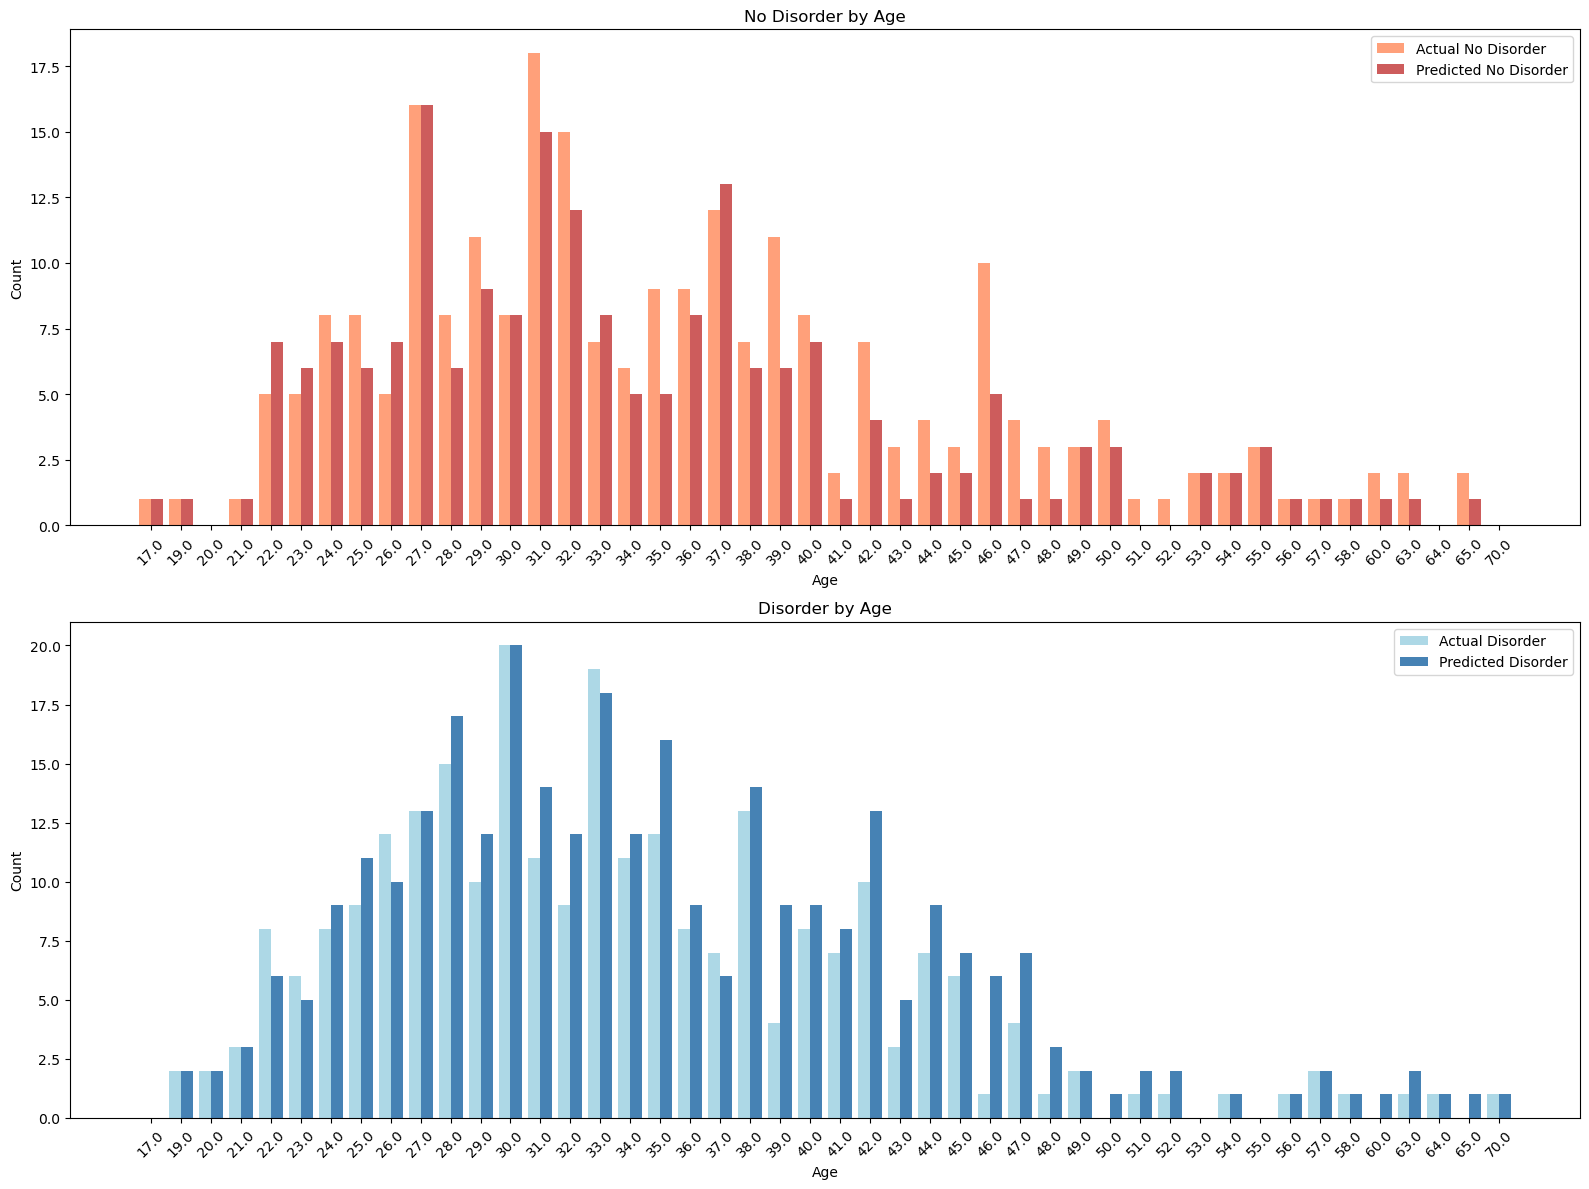

In [32]:
import matplotlib.pyplot as plt

df_plot = X_test_df.copy()
df_plot["True"] = y_test.values
df_plot["Predicted"] = y_pred

true_counts = pd.crosstab(df_plot["What is your age?"], df_plot["True"]).reindex(columns=[0, 1], fill_value=0)
pred_counts = pd.crosstab(df_plot["What is your age?"], df_plot["Predicted"]).reindex(columns=[0, 1], fill_value=0)

ages = true_counts.index
x = range(len(ages))
bar_width = 0.4

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

ax1.bar([i - bar_width/2 for i in x], true_counts[0], width=bar_width, label="Actual No Disorder", color="lightsalmon")
ax1.bar([i + bar_width/2 for i in x], pred_counts[0], width=bar_width, label="Predicted No Disorder", color="indianred")
ax1.set_xlabel("Age")
ax1.set_ylabel("Count")
ax1.set_title("No Disorder by Age")
ax1.legend()
ax1.set_xticks(x)
ax1.tick_params(labelbottom=True)  
ax1.set_xticklabels(ages, rotation=45)

ax2.bar([i - bar_width/2 for i in x], true_counts[1], width=bar_width, label="Actual Disorder", color="lightblue")
ax2.bar([i + bar_width/2 for i in x], pred_counts[1], width=bar_width, label="Predicted Disorder", color="steelblue")
ax2.set_xlabel("Age")
ax2.set_ylabel("Count")
ax2.set_title("Disorder by Age")
ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels(ages, rotation=45)

plt.tight_layout()
plt.show()

#### Key observations:

For No Disorder cases, the model tended to overpredict disorders, suggesting a false positive bias — some healthy individuals were incorrectly classified as having a disorder.

For Disorder cases, the model closely matched the actual distribution across most age groups, especially in older cohorts (ages 50+), indicating strong recall and a low false negative rate.

The use of embeddings improved sensitivity to open-text responses, allowing the model to better capture nuanced expressions of distress or wellbeing.

The overall alignment between predicted and actual distributions confirms that the model generalizes well across age demographics, though further tuning may be needed to reduce age-related misclassifications.

## Synthetic Personas for Model Evaluation

This section evaluates model predictions using two synthetic survey respondents. One persona provides answers indicative of depressive symptoms, while the other does not. The goal is to observe how different models classify these contrasting cases. We apply: Random Forest, Gradient Boosting, Kernel SVM and Multi-Layer Percetron (MLP). The test data is preprocessed using the same pipeline as the training set. Finally, all features are concatenated into a single NumPy array for prediction.


In [33]:
df_test_raw = pd.read_csv("../data/processed/two_test_cases.csv")

df_test_raw[cat_cols] = df_test_raw[cat_cols].fillna("Unknown").astype(str)

X_test_cat = ohe.transform(df_test_raw[cat_cols])

X_test_num = df_test_raw[num_cols].to_numpy()

texts_test = df_test_raw[text_col].tolist()
embeddings_test = model.encode(texts_test)

# Kõik kokku sama järjekorras
X_test_final = np.hstack([X_test_cat, X_test_num, embeddings_test])


In [34]:
y_pred = best_rf.predict(X_test_final)  
print("Random Forest predictions: ", y_pred)

y_pred_svm = best_svc.predict(X_test_final)  
print("Kernel SVM predictions: ", y_pred_svm)


y_pred_lgbm = best_lgbm.predict(X_test_final)  
print("Gradient boosting predictions: ", y_pred_lgbm)

y_prob = model_MLP.predict(X_test_final).ravel()
y_pred_mlp = (y_prob > 0.5).astype(int)
print("MLP predictions: ", y_pred_mlp)

Random Forest predictions:  [0 1]
Kernel SVM predictions:  [0 0]
Gradient boosting predictions:  [0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
MLP predictions:  [0 1]


C:\Users\karelallik\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


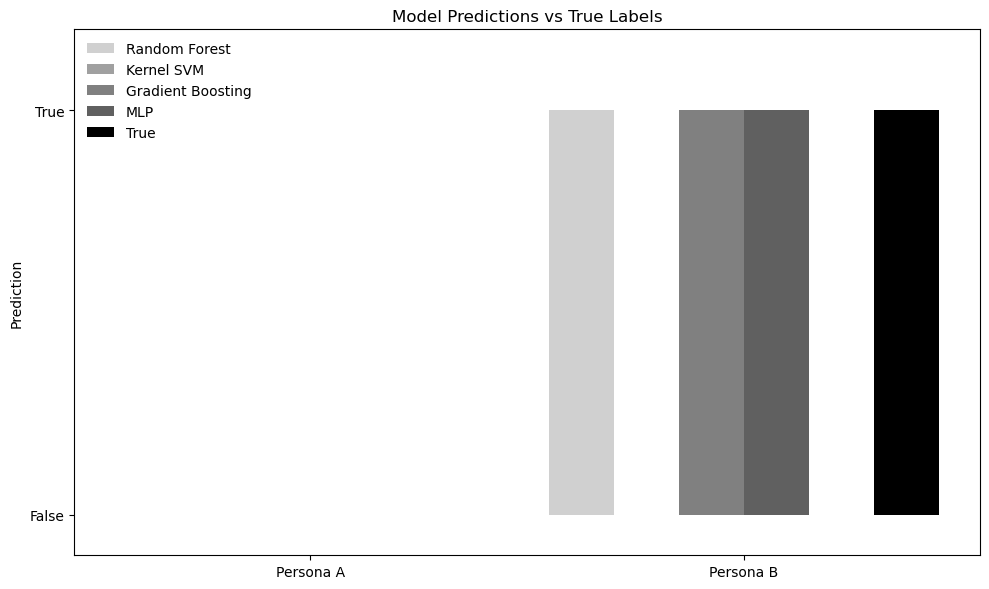

In [35]:
y_true = [0,1]

result = {"Random Forest": y_pred, "Kernel SVM": y_pred_svm, "Gradient Boosting": y_pred_lgbm, "MLP": y_pred_mlp}
df_preds = pd.DataFrame(result, index=["Persona A", "Persona B"])
df_preds["True"] = y_true

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15
x = range(len(df_preds.index))

colors = ["#d0d0d0", "#a0a0a0", "#808080", "#606060"]
true_color = "black"

# Mudelite ennustused
for i, model in enumerate(df_preds.columns[:-1]):
    positions = [j + i * bar_width for j in x]
    ax.bar(positions, df_preds[model], width=bar_width, label=model, color=colors[i])

# Tõeväärtused
true_positions = [j + len(results) * bar_width for j in x]
ax.bar(true_positions, df_preds["True"], width=bar_width, label="True", color=true_color)

# X-telg
ax.set_xticks([j + (len(results)/2)*bar_width for j in x])
ax.set_xticklabels(df_preds.index)

# Y-telg: tekstilised sildid
ax.set_yticks([0, 1])
ax.set_yticklabels(["False", "True"])

ax.set_ylabel("Prediction")
ax.set_title("Model Predictions vs True Labels")
ax.legend(frameon=False)

plt.ylim(-0.1, 1.2)
plt.tight_layout()
plt.show()

Among the two personas, one respondent provided **affirmative** answers to key survey questions: `“Have you ever sought treatment for a mental health disorder from a mental health professional?”` and `“Do you have a family history of mental illness?”`. In addition, this persona expressed **depressive feelings** in the `open‑text response`, further reinforcing the **indication of current mental health concerns**.

Interestingly, both personas answered `“Have you had a mental health disorder in the past?”` with No. This creates a notable contrast: while one persona acknowledges treatment history, family history, and current depressive symptoms, they still deny having had a disorder in the past. This inconsistency highlights the complexity of self‑report data, where individuals may underreport or interpret “past disorder” differently, despite other signals suggesting vulnerability.

## TODO: Might want to change data in two_test_cases and make the table more understandable for viewer